In [149]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Conv1D
from keras.layers import LSTM
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt

In [150]:
df = pd.read_csv('CleanIMDB_train.csv') # Windows single-byte character encoding
df.head()

,review,sentiment
0,steve carell stars person relate to sort of da...,1
1,found enjoyable muppets movie felt light heart...,1
2,altogether bad start program slap face real la...,0
3,saw film tonight nyc landmark sunshine did not...,1
4,much like japanese movies one did not cut it m...,0


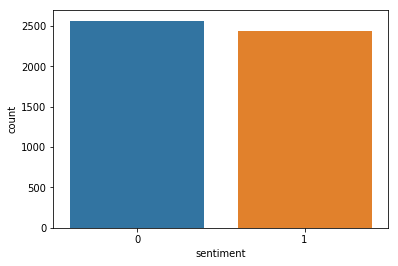

In [151]:
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
sns.countplot(x='sentiment', data=df)

In [152]:
X = df.iloc[:, 0].values
y = df.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [153]:
# Use only thirty percent of the dataset for Keras -1500
# X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train,y_train,test_size=0.20, random_state=42)

In [154]:
tokenizer = Tokenizer(num_words=5000)
# Vocabulary index based on word index frequency - fit_on_texts
# Every word gets unique integer value - word_index["the"] = 1; word_index["cat"] = 2
tokenizer.fit_on_texts(X_train)
# texts_to_sequences - transforms each text in texts to a sequence of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [155]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
# 0 is reserved for padding when more than 100 words length on each sample
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [156]:
# print(X_train)

In [157]:
# Downloaded the GloVe embeddings "glove.68.zip" and use 100d - pre-trained word vectors
# Load the embeddings file: source - https://nlp.stanford.edu/projects/glove/
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [158]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [159]:
# print(embedding_matrix)

In [181]:
# Simple Neural Network - densely connected neural network
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [182]:
print(vocab_size)

34468


In [183]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 100, 100)          3446800   
_________________________________________________________________
flatten_10 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 10001     
Total params: 3,456,801
Trainable params: 10,001
Non-trainable params: 3,446,800
_________________________________________________________________
None


In [184]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 1s 166us/step - loss: 0.6949 - acc: 0.5666 - val_loss: 0.6321 - val_acc: 0.6275
Epoch 2/10
3200/3200 [==============================] - 0s 86us/step - loss: 0.5097 - acc: 0.7672 - val_loss: 0.6045 - val_acc: 0.6913
Epoch 3/10
3200/3200 [==============================] - 0s 75us/step - loss: 0.4280 - acc: 0.8397 - val_loss: 0.6042 - val_acc: 0.6913
Epoch 4/10
3200/3200 [==============================] - 0s 111us/step - loss: 0.3652 - acc: 0.8916 - val_loss: 0.5891 - val_acc: 0.6888
Epoch 5/10
3200/3200 [==============================] - 0s 115us/step - loss: 0.3212 - acc: 0.9131 - val_loss: 0.5904 - val_acc: 0.7000
Epoch 6/10
3200/3200 [==============================] - 0s 125us/step - loss: 0.2844 - acc: 0.9362 - val_loss: 0.5965 - val_acc: 0.6750
Epoch 7/10
3200/3200 [==============================] - 0s 120us/step - loss: 0.2584 - acc: 0.9488 - val_loss: 0.6067 - val_acc: 0.6787
Epo

In [185]:
score = model.evaluate(X_test, y_test, verbose=1)

1000/1000 [==============================] - 0s 205us/step


In [186]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5823627784252167
Test Accuracy: 0.6959999799728394


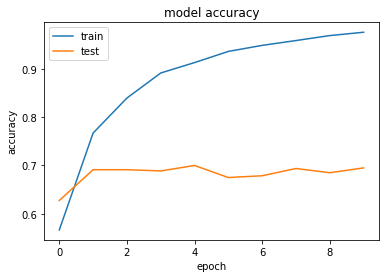

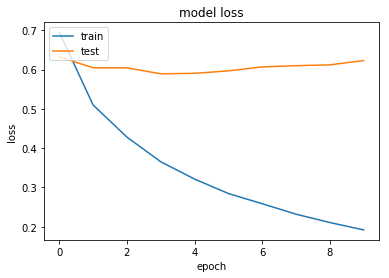

In [187]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [188]:
# 1D Convolutional Neural Network for feature extraction and 1 pooling layer
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(512, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [189]:
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          3446800   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 96, 512)           256512    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 3,703,825
Trainable params: 257,025
Non-trainable params: 3,446,800
_________________________________________________________________
None


In [190]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 19s 6ms/step - loss: 0.6419 - acc: 0.6284 - val_loss: 0.5371 - val_acc: 0.7462
Epoch 2/10
3200/3200 [==============================] - 18s 5ms/step - loss: 0.4332 - acc: 0.8347 - val_loss: 0.4899 - val_acc: 0.7850
Epoch 3/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.3270 - acc: 0.9081 - val_loss: 0.4526 - val_acc: 0.8112
Epoch 4/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.2576 - acc: 0.9453 - val_loss: 0.4374 - val_acc: 0.8025
Epoch 5/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.2064 - acc: 0.9669 - val_loss: 0.4236 - val_acc: 0.8150
Epoch 6/10
3200/3200 [==============================] - 19s 6ms/step - loss: 0.1593 - acc: 0.9853 - val_loss: 0.4150 - val_acc: 0.8163
Epoch 7/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.1254 - acc: 0.9941 - val_loss: 0.4225 - val_acc: 0.8050
Epoch 8/

In [191]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.40050235509872434
Test Accuracy: 0.8270000219345093


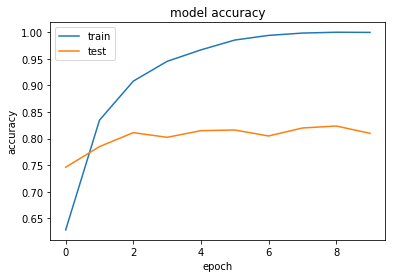

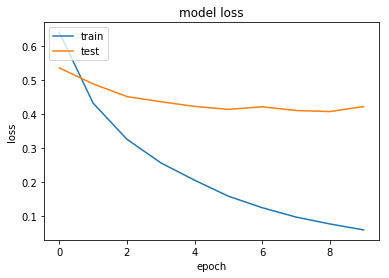

In [192]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [193]:
# Recurrent Neural Network with LSTM (Long Short Term Memory Network) a variant of RNN with 128 neurons
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(512))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [194]:
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 100, 100)          3446800   
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 513       
Total params: 4,702,737
Trainable params: 1,255,937
Non-trainable params: 3,446,800
_________________________________________________________________
None


In [195]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 181s 57ms/step - loss: 0.6865 - acc: 0.5547 - val_loss: 0.6532 - val_acc: 0.6263
Epoch 2/10
3200/3200 [==============================] - 173s 54ms/step - loss: 0.6513 - acc: 0.6313 - val_loss: 0.6494 - val_acc: 0.6325
Epoch 3/10
3200/3200 [==============================] - 179s 56ms/step - loss: 0.5870 - acc: 0.7109 - val_loss: 0.5618 - val_acc: 0.7225
Epoch 4/10
3200/3200 [==============================] - 179s 56ms/step - loss: 0.5657 - acc: 0.7362 - val_loss: 0.6469 - val_acc: 0.6450
Epoch 5/10
3200/3200 [==============================] - 176s 55ms/step - loss: 0.6190 - acc: 0.6463 - val_loss: 0.6682 - val_acc: 0.5738
Epoch 6/10
3200/3200 [==============================] - 184s 58ms/step - loss: 0.6310 - acc: 0.6434 - val_loss: 0.6752 - val_acc: 0.6612
Epoch 7/10
3200/3200 [==============================] - 195s 61ms/step - loss: 0.5752 - acc: 0.7250 - val_loss: 0.5628 - val_acc: 0

In [196]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.48435640144348147
Test Accuracy: 0.7739999890327454


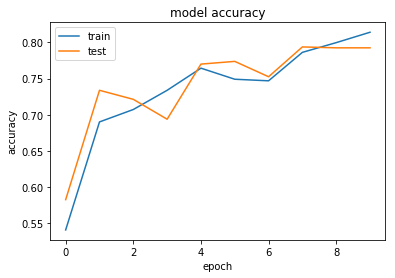

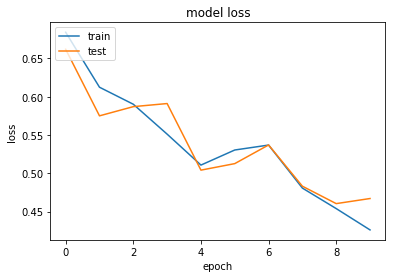

In [176]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()